In [1]:
import stlearn as st
st.settings.set_figure_params(dpi=120)
import warnings
warnings.filterwarnings('ignore')

## Prepare data

In [2]:
data = st.Read10X(path="/home/d.pham/10X/TBI_C1/")
data.var_names_make_unique()
tmp = data[:,["Fcrls","Tmem119"]].to_df()
microglia_spots = tmp.sum(axis=1)[tmp.sum(axis=1)>1].index

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
import pandas as pd
# Setup list of related and marker genes
upgenes= list(pd.read_table("/home/d.pham/Downloads/up1000.txt",header=None)[0])
downgenes = list(pd.read_table("/home/d.pham/Downloads/down1000.txt",header=None)[0])
merged_upgenes = []
for gene in upgenes:
    if gene in data.var_names:
        merged_upgenes.append(gene)
merged_downgenes = []
for gene in downgenes:
    if gene in data.var_names:
        merged_downgenes.append(gene)
merged_upgenes.append("Fcrls")
merged_upgenes.append("Tmem119")

## Preprocessing

In [6]:
import scanpy as sc
sc.pp.filter_cells(data, min_genes=200)
sc.pp.filter_genes(data, min_cells=3)
data.var['mt'] = data.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
data = data[:,list(set(merged_upgenes+merged_downgenes) & set(data.var_names))]
data = data[data.obs.n_genes_by_counts < 7500, :]


Trying to set attribute `.obs` of view, copying.


In [7]:
data.raw = data

In [8]:
st.pp.normalize_total(data)
st.pp.log1p(data)

sc.pp.highly_variable_genes(data, min_mean=0.0025, max_mean=3, min_disp=0.5)
data = data[:, data.var.highly_variable]

st.pp.scale(data, max_value=10)


Normalization step is finished in adata.X
Log transformation step is finished in adata.X
Scale step is finished in adata.X


# Run stSME

In [9]:
st.em.run_pca(data,n_comps=25,random_state=0)

st.pp.tiling(data,out_path="../tiling",crop_size = data.uns["spatial"]["Visium_LP4_map_C1"]["scalefactors"]["spot_diameter_fullres"])
st.pp.extract_feature(data)
st.spatial.morphology.adjust(data,use_data="X_pca",radius=40,method="mean")

Tiling image:   4%|▎          [ time left: 00:02 ]

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


Tiling image: 100%|██████████ [ time left: 00:00 ]
Extract feature: 100%|██████████ [ time left: 00:00 ]
Adjusting data:   2%|▏          [ time left: 00:05 ]

The morphology feature is added to adata.obsm['X_morphology']!


Adjusting data: 100%|██████████ [ time left: 00:00 ]

The data adjusted by morphology is added to adata.obsm['X_pca_morphology']


Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 


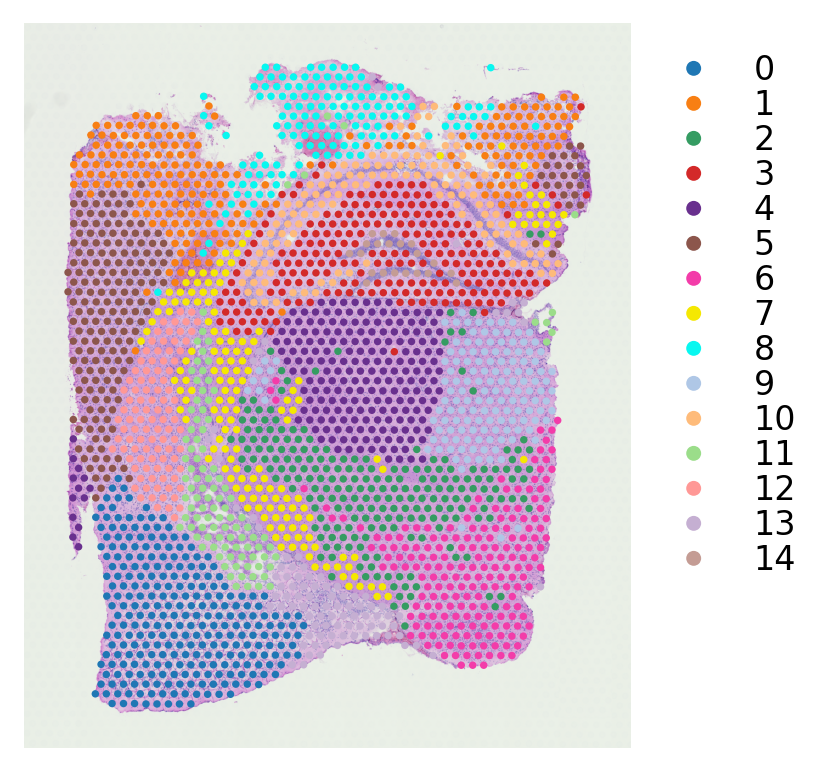

In [10]:
st.settings.set_figure_params(dpi=120)
st.pp.neighbors(data,n_neighbors=25,use_rep='X_pca',random_state=0)
sc.tl.leiden(data,resolution=1,random_state=0)
st.settings.set_figure_params(dpi=120)
st.pl.cluster_plot(data,use_label="leiden")

## Run PSTS

In [11]:
import numpy as np
# Choose root at the edge of cluster 1 (damaged sites)
data.uns["iroot"] = st.spatial.trajectory.set_root(data,use_label="leiden",cluster=1,use_raw=True)
st.spatial.trajectory.pseudotime(data,eps=100,use_label="leiden",threshold_spots=15,reverse=True)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
All available trajectory paths are stored in adata.uns['available_paths'] with length < 4 nodes


In [12]:
# Filter spots
micro_spot_filter = []
for ind in microglia_spots:
    if ind in data.obs_names:
        micro_spot_filter.append(ind)

data = data[micro_spot_filter]

In [13]:
st.spatial.trajectory.pseudotimespace_global(data,use_label="leiden",list_clusters=["1","3","4","6"],)


Screening:   0%|           [ time left: ? ]Trying to set attribute `.uns` of view, copying.


Screening PTS global graph...


Screening: 100%|██████████ [ time left: 00:00 ]
Calculating: 100%|██████████ [ time left: 00:00 ]


Calculate the graph dissimilarity using Laplacian matrix...
The optimized weighting is: 0.53
Start to construct the trajectory: 6 -> 4 -> 3 -> 1


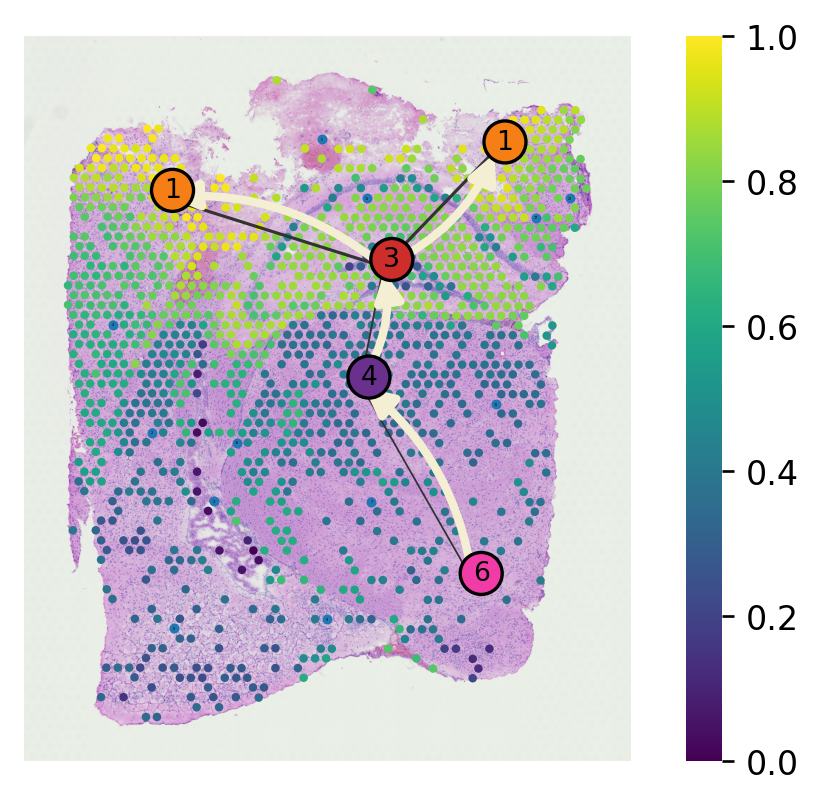

In [16]:
st.pl.trajectory.pseudotime_plot(data,use_label="leiden",list_clusters=["1","3","4","6"],show_graph=True, pseudotime_key="dpt_pseudotime",
                                 edge_alpha=1.0,node_size=7,show_trajectories=True)

## Variogram

In [17]:
from skgstat import Variogram

In [18]:
V_mor = Variogram(coordinates=data.obs[["imagecol","imagerow"]].values, values=data.obs["dpt_pseudotime"].values,
            model='gaussian')

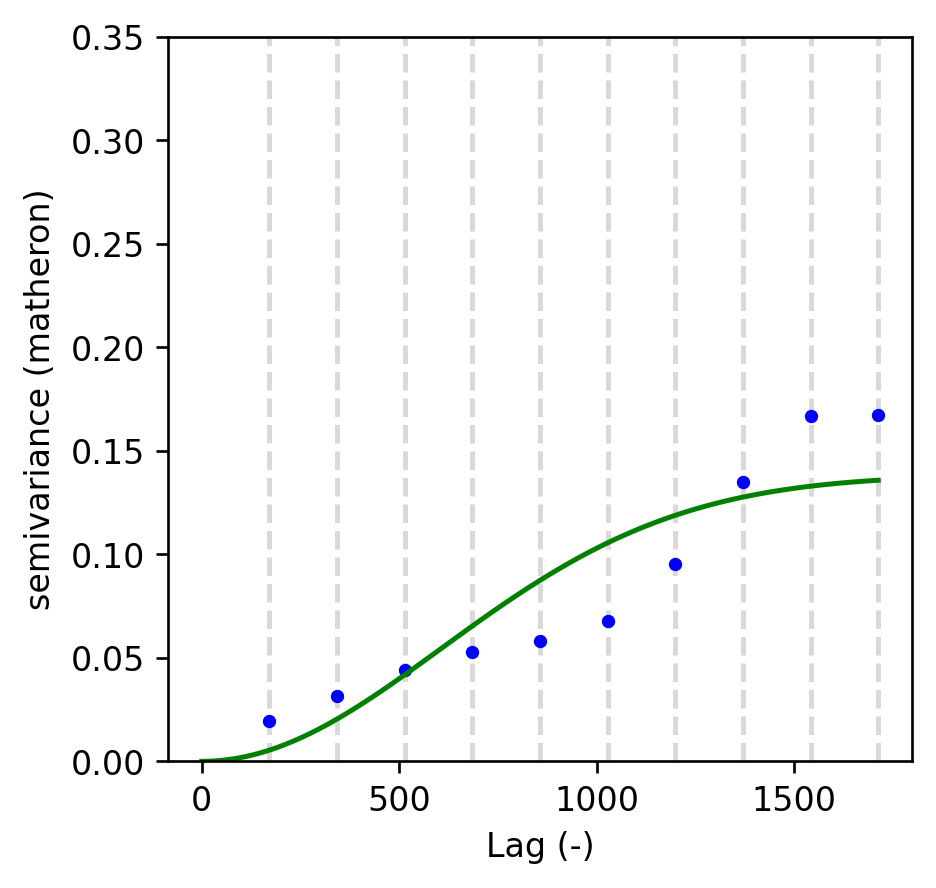

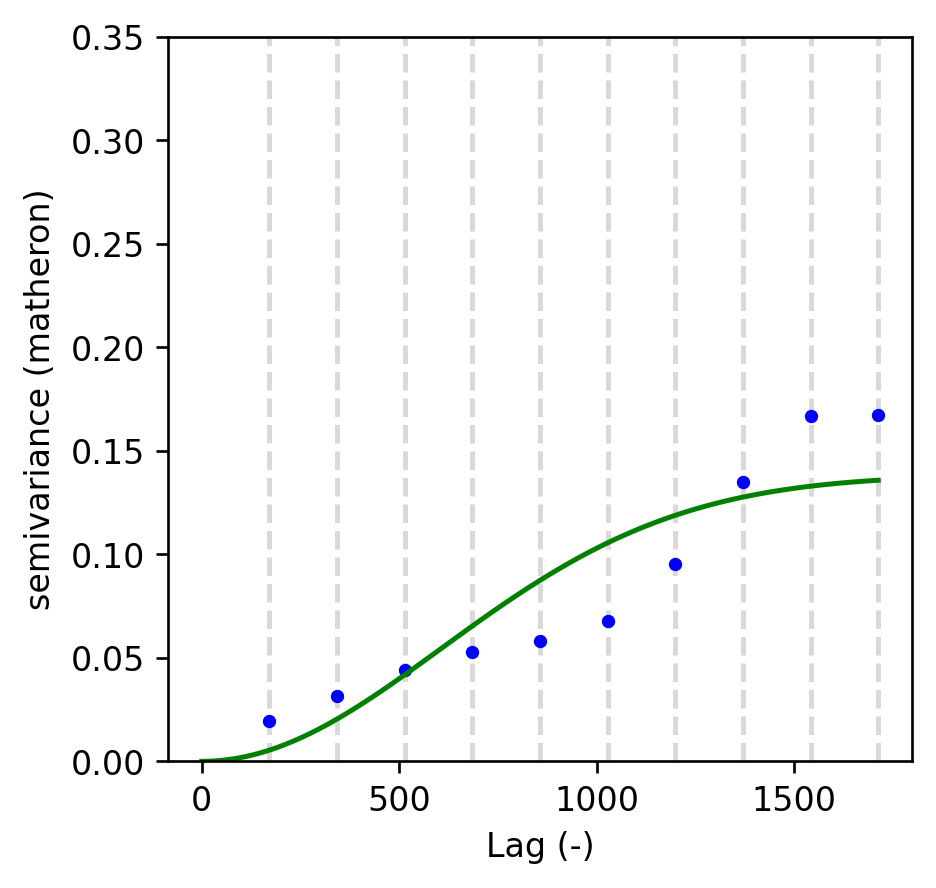

In [26]:
import matplotlib.pyplot as plt
fig, a = plt.subplots(figsize=(4,4))
a.set_ylim(0,0.35)
V_mor.plot(hist=False,axes=a)

## Transition markers

In [29]:
def get_rank_cor(adata,screening_genes=None,use_raw_count=False):
    if use_raw_count:
        tmp = adata.copy()
        tmp.X = adata.layers["raw_count"]
        tmp = tmp.to_df()
    else:
        tmp = adata.to_df()
    if screening_genes != None:
        tmp = tmp[screening_genes]
    dpt = adata.obs["dpt_pseudotime"].values
    genes = []
    score = []
    pvalue = []
    for gene in list(adata.var.index):
        genes.append(gene)
        score.append(spearmanr(tmp[gene].values,dpt)[0])
        pvalue.append(spearmanr(tmp[gene].values,dpt)[1])
    import pandas as pd
    final = pd.DataFrame(
    {'gene': genes,
     'score': score,
     'p-value': pvalue
    })
    return final


In [30]:
def create_query(list_sub_clusters):
    ini = ''
    for sub in list_sub_clusters:
        ini = ini + 'leiden == "' + str(sub) + '" | '
    return ini[:-2]

In [31]:
query_adata = data[data.obs.query(create_query(["1","3","4","6"])).index]

In [32]:
from scipy.stats import spearmanr
cutoff_spearman = 0.3
cutoff_pvalue = 0.05
spearman_result = get_rank_cor(query_adata,screening_genes=None,use_raw_count=False)
spearman_result = spearman_result[spearman_result['p-value'] < cutoff_pvalue]
positive = spearman_result[spearman_result['score'] >= cutoff_spearman].sort_values("score",ascending=False)
negative = spearman_result[spearman_result['score'] <= cutoff_spearman*(-1)].sort_values("score")

result = pd.concat([positive,negative])

In [33]:
data.uns['clade_1'] = result

In [34]:
import gseapy

In [35]:
enr = gseapy.enrichr(list(data.uns["clade_1"][data.uns["clade_1"]["score"]>0]["gene"]),
                 gene_sets='WikiPathways_2019_Mouse',
                 organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

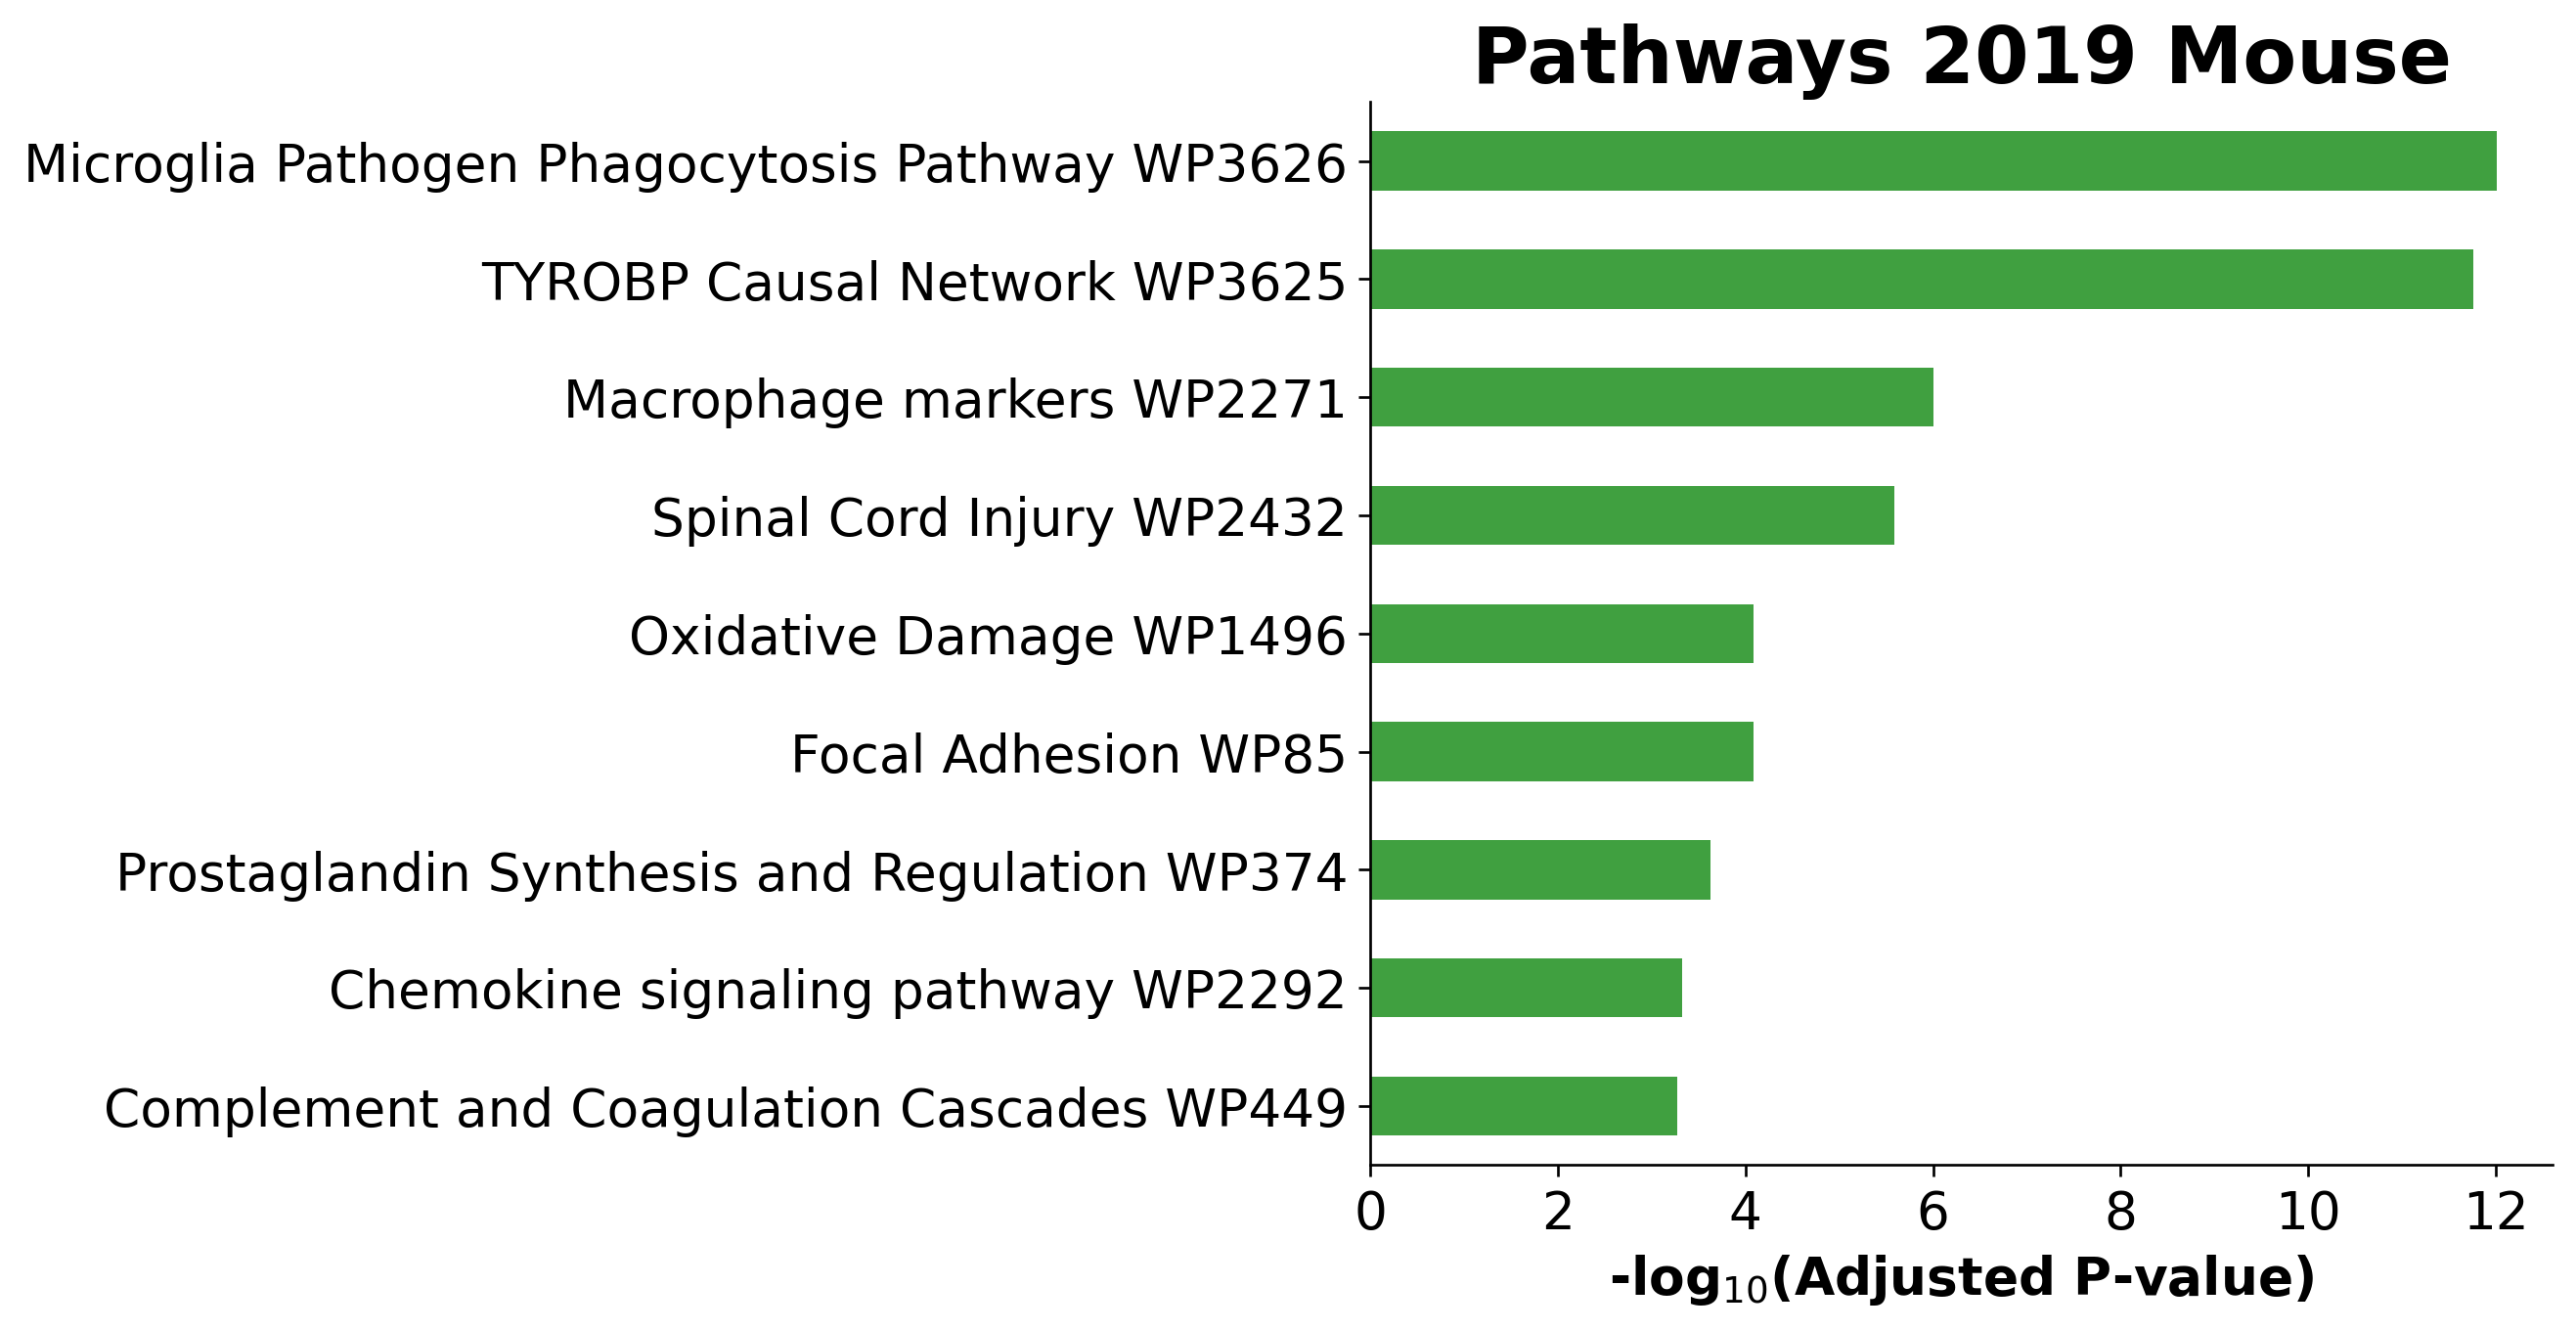

In [36]:
# to save your figure, make sure that ``ofname`` is not None
gseapy.barplot(enr.res2d,title='Pathways 2019 Mouse',color="green",top_term=9,cutoff=0.13)